

Per il coach che correggera' questo progetto:

1. Il progetto viene mostrato seguendo la pipeline standard, dall'import alla discussione finale. Ho inserito alcuni capitoli iniziali con delle funzioni costruite da me. Ognuna ha un'accurata documentazione. In particolare:

- (-1): contiene installazioni ed imports necessari;

- (A): contiene la definizione della classe per l'Early Stopping;

- (B): contiene tutto ciò che è necessario per eseguire il training di un modello ed analizzare i risultati. La sottodivisione riguarda funzioni da usare sul train e validation set oppure sul test set. Inoltre durante il training vengono automaticamente salvate tutte le quantità necessarie per visualizzare i plot del training (funzione `training_results`) ed a studiare le metriche successivamente (funzioni `plot_confusion_matrix` e `metrics_report`);

- (C): contiene una suite completa per la visualizzazione delle immagini, dall'inversione della normalizzazione (funzione `before_preprocessing`), all' esplorazione visiva del dataset (funzione `dataset_inspection`) e delle predizioni (funzione `show_predictions`). Questa suite serve per studiare in dettaglio il dataset ed i risultati del training, per capire dove il modello sbaglio e possibilmente avere un'idea del perche';

- (D): contiene la definizione delle classi per la model explainability, con GradCAM e Saliency Map definite manualmente. Sono anche presenti delle funzioni per usare al meglio la libreria 'captum'. Questi strumenti sono stati utilizzati nel notebook per cercare di capire se i modelli stanno 'guardando' le features importanti nelle immagini.

2. Ho impostato il notebook in modo estremamente didattico, con spiegazioni dettagliate di ogni passaggio (probabilmente spiegazioni ridondanti, ma meglio abbondare in questo contesto).

3. Sono consapevole che le funzioni scritte manualmente da me potrebbero essere rese molto piu' robuste (controlli sugli input, type hints, eccetera), ma ho comunque messo documentazione tramite docstring. Per tenere il progetto autoconsistente ma senza esagerare, ho usato definizioni funzionali al contesto e che possono essere riutilizzate in molti altri contesti;

4. Il notebook è stato sviluppato in modo da poter essere rieseguito integralmente dall’inizio senza errori o dipendenze esterne, ed inoltre i risultati sono (il piu' possibile) riproducibili.

5. **Non ho copiato nessun codice da fonti esterne**, usando solo la reference ufficiale di PyTorch e Torchvision ove necessario.


Chiedo al coach una valutazione il piu' possibile severa. Se fosse possibile, gradirei sapere la votazione, per poter tenere traccia delle mie skills in futuro.

# (-1) Imports, reproducibility and device setting

In [1]:
!pip install -q torchinfo timm

# basic imports
import os

import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import KFold

import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as T
import albumentations as A
import torch.nn.functional as F
from albumentations.pytorch import ToTensorV2

# utils
from tqdm import tqdm
from IPython.display import display
from torchinfo import summary

In [2]:
from torch.amp import autocast, GradScaler

cuda_available = torch.cuda.is_available()
scaler = GradScaler(enabled = cuda_available)

device = torch.device("cuda" if cuda_available else "cpu")

In [3]:
import random
seed = 156
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed);

if cuda_available:
    torch.cuda.manual_seed_all(seed)

# (A) Early Stopping Class

In [4]:
class EarlyStopping:
  def __init__(self, mode = "d", patience = 5, delta = 0, verbose = False, path = 'checkpoint.pt'):
    """
    mode: use "d" (default) for a metric that must be minimized, "c" otherwise
    patience: Number of epochs to wait for improvement: after
             'patient number of epochs' without improvement, training will stop
    delta: if the validation metric does not improve by at least 'delta' > 0,
           it is not considered an improvement.
    verbose: if True, print a message when validation metric does not improve
    path: path to save the model checkpoint

    """
    self.patience = patience
    self.delta = delta
    self.verbose = verbose
    self.path = path
    self.counter = 0 # counter to track epochs without improvement
    self.best_score = None
    self.early_stop = False # bool to indicate whether to stop training
    self.mode = mode

  def save_checkpoint(self, model):
    os.makedirs(os.path.dirname(self.path), exist_ok = True)
    torch.save(model.state_dict(), self.path)

  def __call__(self, val_metric, model):
    if self.best_score is None:
      self.best_score = val_metric
      self.save_checkpoint(model)

    elif (self.mode == "d" and val_metric < self.best_score - self.delta) or \
          (self.mode == "c" and val_metric > self.best_score + self.delta):
        self.best_score = val_metric
        self.save_checkpoint(model)
        self.counter = 0

    else:
      self.counter += 1
      if self.verbose:
        print(f'Epochs without improvement: {self.counter}')
      if self.counter >= self.patience:
                self.early_stop = True

# (B) Classification Utilities

## Training and Validation Utilities

### train_classification

In [5]:
def train_classification(model, loss_fn, optimizer, train_loader, val_loader, scheduler = None, epochs = 1,
                         verbose = False, confusion_matrix_data = False, early_stopping = None):
  """
  model: a model object from the class torch.nn.Module of PyTorch;
  loss_fn: a loss function. Example: loss_fn = torch.nn.CrossEntropyLoss();
  optimizer: an object of the class torch.optim. Example: optimizer = torch.optim.SGD();
  train_loader and val_loader: train and validation loader from the class torch.utils.data.DataLoader;
  scheduler: an object from torch.optim.lr_scheduler. Example: scheduler = torch.optim.lr_scheduler.StepLR(optimizer).
             Default is scheduler = None;
  epochs: number of training epochs. Default is epochs = 1;
  verbose: if True, it prints at each epoch train and validation losses and accuracies;
  confusion_matrix_data: if False, the function returns a list of lists with
                                   train_losses, train_accuracies, val_losses, val_accuracies
                                   for each epoch;
                         if True, the function returns also a list of lists with
                                   all_y_train, all_yhat_train, all_y_val, all_yhat_val
                                   that can be used to show the confusion matrix later;
  early_stopping: an object of the class EarlyStopping. Default is early_stopping = None.
  """

  train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
  all_y_train, all_yhat_train, all_y_val, all_yhat_val = [], [], [], []

  for epoch in tqdm(range(1, epochs + 1)):
    train_loss_of_batches, train_correct_predictions_of_batches = 0.0, 0.0
    val_loss_of_batches, val_correct_predictions_of_batches = 0.0, 0.0

    #################### training part ####################

    model.train()
    total_number_of_examples = 0
    for X_train, y_train in train_loader:
      batch_size = y_train.shape[0]
      total_number_of_examples += batch_size
      X_train, y_train = X_train.to(device), y_train.to(device)
      with autocast(device_type = device.type, dtype = torch.float16, enabled = cuda_available):
        logitshat_train = model(X_train)
        train_loss_of_batch = loss_fn(logitshat_train, y_train)
      optimizer.zero_grad()
      scaler.scale(train_loss_of_batch).backward()
      scaler.step(optimizer)
      scaler.update()
      train_loss_of_batches += train_loss_of_batch.item() * batch_size

      with torch.no_grad():
        yhat_train = torch.argmax(logitshat_train, dim = 1)
        train_correct_prediction_of_batch = (yhat_train == y_train).sum().item()
        train_correct_predictions_of_batches += train_correct_prediction_of_batch

    # it is useful normalize the loss, only for comparing purposes
    train_losses.append(train_loss_of_batches/total_number_of_examples)
    train_accuracies.append(train_correct_predictions_of_batches/total_number_of_examples)

    #################### validation part ####################

    total_number_of_examples = 0
    model.eval()
    for X_val, y_val in val_loader:
      with torch.no_grad():
        batch_size = y_val.shape[0]
        total_number_of_examples += batch_size
        X_val, y_val = X_val.to(device), y_val.to(device)
        with autocast(device_type = device.type, dtype = torch.float16, enabled = cuda_available):
          logitshat_val = model(X_val)
          val_loss_of_batch = loss_fn(logitshat_val, y_val)
        val_loss_of_batches += val_loss_of_batch.item() * batch_size
        yhat_val = torch.argmax(logitshat_val, dim = 1)
        val_correct_prediction_of_batch = (yhat_val == y_val).sum().item()
        val_correct_predictions_of_batches += val_correct_prediction_of_batch

    # it is useful normalize the loss, only for comparing purposes
    val_losses.append(val_loss_of_batches/total_number_of_examples)
    val_accuracies.append(val_correct_predictions_of_batches/total_number_of_examples)

    if verbose:
      print("\n","-"*160)
      print(f"\t\t\t\t\t\t\t\t\t AT EPOCH {epoch}")
      print(f"Train accuracy: {np.round(float(train_accuracies[-1]),3)}",
            " -------------- "
            f"Valid accuracy: {np.round(float(val_accuracies[-1]),3)}.")
      print(f"Train loss: {np.round(float(train_losses[-1]),3)}",
            " --------------  ",
            f"Valid loss: {np.round(float(val_losses[-1]),3)}.")

    if early_stopping is not None:
            early_stopping(val_losses[-1], model)
            if early_stopping.early_stop == True:
                print("\nEarly stopping triggered.")
                break

    if scheduler is not None:
        if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
            scheduler.step(val_losses[-1])
        else:
            scheduler.step()

  #################### the part below is needed to
  # construct all the predictions with the best weights  ####################
  if early_stopping is not None and early_stopping.early_stop:
      model.load_state_dict(torch.load(early_stopping.path))

  if confusion_matrix_data:
    model.eval()
    with torch.no_grad():
      for X_train, y_train in train_loader:
        X_train, y_train = X_train.to(device), y_train.to(device)
        with autocast(device_type = device.type, dtype = torch.float16, enabled = cuda_available):
          logitshat_train = model(X_train)
        yhat_train = torch.argmax(logitshat_train, dim = 1)
        all_y_train.extend(y_train.cpu().numpy())
        all_yhat_train.extend(yhat_train.cpu().numpy())

      for X_val, y_val in val_loader:
        X_val, y_val = X_val.to(device), y_val.to(device)
        with autocast(device_type = device.type, dtype = torch.float16, enabled = cuda_available):
          logitshat_val = model(X_val)
        yhat_val = torch.argmax(logitshat_val, dim = 1)
        all_y_val.extend(y_val.cpu().numpy())
        all_yhat_val.extend(yhat_val.cpu().numpy())

  if confusion_matrix_data == False:
    return [train_losses, train_accuracies, val_losses, val_accuracies]
  else:
    return [train_losses, train_accuracies, val_losses, val_accuracies],[all_y_train, all_yhat_train, all_y_val, all_yhat_val]

### training_results

In [6]:
def training_results(train_losses, train_accuracies, val_losses, val_accuracies, size = (12, 5)):

  fig, (ax1, ax2) = plt.subplots(1, 2, figsize = size)
  epochs = len(train_accuracies)
  x_axis = range(1, epochs + 1)

  # left: Loss
  ax1.plot(x_axis, train_losses, label = 'Training Loss', color = 'blue', linestyle = '-')
  ax1.plot(x_axis, val_losses, label = 'Validation Loss', color = 'red', linestyle = '-')
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Loss')
  ax1.tick_params(axis = 'y')
  ax1.legend(loc = 'best')
  ax1.set_title('Training & Validation Loss')
  ax1.grid(True)

  # right: Accuracy
  ax2.plot(x_axis, train_accuracies, label='Train Accuracy', color = 'blue', linestyle = '-')
  ax2.plot(x_axis, val_accuracies, label='Validation Accuracy', color = 'red', linestyle = '-')
  ax2.set_xlabel('Epoch')
  ax2.set_ylabel('Accuracy')
  ax2.tick_params(axis = 'y')
  ax2.legend(loc = 'best')
  ax2.set_title('Training & Validation Accuracy')
  ax2.grid(True)

  plt.tight_layout()
  plt.show()
  plt.close()

### plot_confusion_matrix

In [7]:
def plot_confusion_matrix(cm_train = None, cm_val = None, all_y = [], size = (10,4)):

  """
  cm_train and cm_test: confusion matrices fron train and test coming from the method confusion_matrix().
  all_y: list of lists of all_y_train, all_yhat_train, all_y_val, all_yhat_val
  """
  if all_y != []:
    y_train, yhat_train, y_val, yhat_val = all_y[0], all_y[1], all_y[2], all_y[3]
    y_train = np.array(y_train)
    yhat_train = np.array(yhat_train)
    y_val = np.array(y_val)
    yhat_val = np.array(yhat_val)
    cm_train = confusion_matrix(y_train, yhat_train)
    cm_val = confusion_matrix(y_val, yhat_val)

  df_cm_train = pd.DataFrame(cm_train)
  df_cm_val = pd.DataFrame(cm_val)

  fig, axes = plt.subplots(1,2,figsize = size)
  sns.heatmap(df_cm_train, cmap = "Blues", annot = True, annot_kws = {'size': 13}, ax = axes[0])
  sns.heatmap(df_cm_val, cmap = "Reds", annot = True, annot_kws = {'size': 13}, ax = axes[1])

  axes[0].set_title(f"Confusion Matrix - Train set")
  axes[0].set_xlabel("Predicted Label")
  axes[0].set_ylabel("True Label")

  axes[1].set_title(f"Confusion Matrix - Validation/Test set")
  axes[1].set_xlabel("Predicted Label")
  axes[1].set_ylabel("True Label")

  plt.show()
  plt.close()

### metrics_report

In [8]:
def metrics_report(y_train, yhat_train, y_val, yhat_val, size = (10,4), verbose = False):

  """
  verbose: if True, the function prints a summary of the standard metrics of a classification problem, both for the train and validation/test set.
  return: model, predictions, metrics, metrics_df, confusion_matrices
  """

  y_train = np.array(y_train)
  yhat_train = np.array(yhat_train)
  y_val = np.array(y_val)
  yhat_val = np.array(yhat_val)

  metrics = ["Accuracy", "F1-score", "Precision", "Recall"]
  split = ["Train", "Validation/Test"]

  # train metrics

  accuracy_train = accuracy_score(y_train, yhat_train)
  f1_train = f1_score(y_train, yhat_train, average = 'macro')
  precision_train = precision_score(y_train, yhat_train, average = 'macro')
  recall_train = recall_score(y_train, yhat_train, average = 'macro')

  # test metrics

  accuracy_val = accuracy_score(y_val, yhat_val)
  f1_val = f1_score(y_val, yhat_val, average = 'macro')
  precision_val = precision_score(y_val, yhat_val, average = 'macro')
  recall_val = recall_score(y_val, yhat_val, average = 'macro')

  # visualization

  metrics_train = [accuracy_train, f1_train, precision_train, recall_train]
  metrics_val = [accuracy_val, f1_val, precision_val, recall_val]
  metrics_df = pd.DataFrame([metrics_train, metrics_val], columns = metrics, index = split)

  cm_train = confusion_matrix(y_train, yhat_train)
  cm_val = confusion_matrix(y_val, yhat_val)
  confusion_matrices = [cm_train, cm_val]

  if verbose:
    display(metrics_df)
    plot_confusion_matrix(cm_train, cm_val, size = size)

  return metrics_train, metrics_val, metrics_df, confusion_matrices

## Test Utilities

### test_model

In [9]:
def test_model(model, loss_fn, test_loader, verbose = False, size = (4, 4)):

  all_y_test, all_yhat_test = [], []

  model.eval()
  for X_test, y_test in test_loader:
    with torch.no_grad():
      X_test, y_test = X_test.to(device), y_test.to(device)
      with autocast(device_type = device.type, dtype = torch.float16, enabled = cuda_available):
        logitshat_test = model(X_test)
      yhat_test = torch.argmax(logitshat_test, dim = 1)
      all_y_test.extend(y_test.cpu().numpy())
      all_yhat_test.extend(yhat_test.cpu().numpy())

  metrics = ["Accuracy", "F1-score", "Precision", "Recall"]
  split = ["Test"]

  y_test = np.array(all_y_test)
  yhat_test = np.array(all_yhat_test)

  # metrics computation

  accuracy_test = accuracy_score(y_test, yhat_test)
  f1_test = f1_score(y_test, yhat_test, average = 'macro')
  precision_test = precision_score(y_test, yhat_test, average = 'macro')
  recall_test = recall_score(y_test, yhat_test, average = 'macro')

  metrics_test = [accuracy_test, f1_test, precision_test, recall_test]
  metrics_df = pd.DataFrame([metrics_test], columns = metrics, index = split)

  cm_test = confusion_matrix(y_test, yhat_test)

  if verbose:
    display(metrics_df)
    df_cm_test = pd.DataFrame(cm_test)
    plt.figure(figsize = size)
    sns.heatmap(df_cm_test, cmap = "Reds", annot = True, annot_kws = {'size': 13})

    plt.title(f"Confusion Matrix - Test set")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.show()
    plt.close()

  return metrics_test, metrics_df, cm_test

# (C) Image Visualization Utilities

In [10]:
def before_preprocessing(X, mean = None, std = None):
  '''
  function to invert the torchvision.transforms.Normalize.
  X: torch tensors (C, H, W) where colors are in RGB;
  mean and std: must be in RGB format;
  return: RGB for plotting with pixels in [0, 1.0] range.
  '''
  number_of_channels = X.shape[0]
  if mean == None:
    mean = [0] * number_of_channels
  if std == None:
    std = [1] * number_of_channels

  mean = np.array(mean)
  std = np.array(std)

  mean_np = mean.reshape((number_of_channels, 1, 1))
  std_np = std.reshape((number_of_channels, 1, 1))
  x = np.array(X)

  x = std_np * x + mean_np
  x = np.clip(x, 0, 1.0) # x can contain negative values near to 0
                           # or greater than 1.0
  return np.array(x)

In [11]:
def show_image(X, title = "", size = (2, 2)):
  '''
  X: torch or numpy array with shape (C, H, W)
  '''
  x = np.array(X)
  x = np.transpose(x, (1, 2, 0)) # shape: (H, W, C)
  plt.figure(figsize = size)
  plt.imshow(x)
  plt.axis('off')
  plt.title(f"Ground truth: {title}")
  plt.show()
  plt.close()

In [12]:
def dataset_inspection(loader, mean = None, std = None, int_to_labels = {},
                       num_images = 8, num_columns = 4, size = (2, 2)):
  '''
  int_to_labels: a dictionary in the form {integer : 'label'}
  '''
  loader_iterator = iter(loader)
  processed_images, y = next(loader_iterator)
  processed_images, y = processed_images.to(device), y.to(device)
  batch_size = processed_images.shape[0]
  if num_images > batch_size:
    num_images = batch_size

  num_rows = int(num_images/num_columns if num_images%num_columns == 0 else num_images//num_columns + 1)

  fig = plt.figure(figsize = size)

  for index in range(num_images):
    ground_truth = y[index].item()
    if int_to_labels != {}:
      ground_truth = int_to_labels[ground_truth]
    plt.subplot(num_rows, num_columns , index + 1)
    img_before_preprocessing = before_preprocessing(processed_images[index].cpu(),
                                                    mean = mean, std = std)
    plt.imshow(img_before_preprocessing.transpose(1, 2, 0))
    plt.axis('off')
    plt.title(f"Ground truth: {ground_truth}", fontsize = 12)
    plt.tight_layout()
  plt.show()
  plt.close()

In [13]:
def show_predictions(model, loader, mean = None, std = None, int_to_labels = {},
                     num_images = 8, num_columns = 4, size = (2, 2)):
  '''
  int_to_labels: a dictionary in the form {integer : 'label'}
  '''
  loader_iterator = iter(loader)
  processed_images, y = next(loader_iterator)
  processed_images, y = processed_images.to(device), y.to(device)
  batch_size = processed_images.shape[0]
  if num_images > batch_size:
    num_images = batch_size

  model.eval()
  with torch.no_grad():
    logitshat = model(processed_images)
    yhat = torch.argmax(logitshat, dim = 1)

  num_rows = int(num_images/num_columns if num_images%num_columns == 0 else num_images//num_columns + 1)

  fig = plt.figure(figsize = size)

  for index in range(num_images):
    true_label = y[index].item()
    predicted_label = yhat[index].item()
    if int_to_labels != {}:
      true_label = int_to_labels[true_label]
      predicted_label = int_to_labels[predicted_label]
    plt.subplot(num_rows, num_columns , index + 1)
    img_before_preprocessing = before_preprocessing(processed_images[index].cpu(),
                                                    mean = mean, std = std)
    plt.imshow(img_before_preprocessing.transpose(1, 2, 0))
    plt.axis('off')
    color = 'green' if true_label == predicted_label else 'red'
    plt.title(f"True: {true_label} | Predicted: {predicted_label}",
              c = color, fontsize = 10)
    plt.tight_layout()
  plt.show()
  plt.close()

# (D) Explainability Utilities

## Saliency Map

In [14]:
class SaliencyMAP:
  def __init__(self,
               model: nn.Module):
    self.model = model

  def __call__(self, X: torch.Tensor, class_idx: int = None) -> np.array:
    """
    class_idx: to study the SaliencyMAP for a specific class. The default is None, and the
               SaliencyMAP is computed for the predicted class.
    X: batch of images, with shape [B, 3, H, W]
    """
    batch_size = X.shape[0]
    H = X.shape[2]
    W = X.shape[3]
    X_with_grad = X.clone().detach().requires_grad_(True)
    self.model.eval()
    logitshat = self.model(X_with_grad) # shape: [B, num_classes]

    if class_idx is None or class_idx > logitshat.shape[1] - 1:
      class_idx = torch.argmax(logitshat, dim = 1) # shape: [B]
    else:
      class_idx = torch.tensor([class_idx] * batch_size, device = X.device) # shape: [B]

    scores = logitshat.gather(1, class_idx.view(-1, 1)).squeeze() # shape: [B]

    self.model.zero_grad()
    torch.sum(scores).backward()

    SM_k_ij = X_with_grad.grad.detach() # shape: [B, C, H, W]
    SM_ij, _ = torch.max(SM_k_ij.abs(), dim = 1, keepdim = True) # shape: [B, 1, H, W]
    # normalization of the saliency map
    min = torch.amin(SM_ij.view(batch_size, -1), dim = 1).view(batch_size, 1, 1, 1)
    max = torch.amax(SM_ij.view(batch_size, -1), dim = 1).view(batch_size, 1, 1, 1)
    normalized_SM_ij = (SM_ij - min) / (max - min + 1e-8)

    return normalized_SM_ij.detach().cpu().numpy() # shape: [B, 1, H, W]

## GradCAM

In [15]:
class GradCAM:
  def __init__(self,
               model: nn.Module,
               target_layer: nn.Module): # target layer for the GradCAM
    self.model = model
    self.target_layer = target_layer
    self.feature_maps = None
    self.gradients = None
    self._register_hooks()

  def _register_hooks(self):

    def forward_hook(layer, input, output):
      self.feature_maps = output.detach() # shape: [BATCH_SIZE, N_f, H_l, W_l]
      # print(f"Triggered with shape: {output.shape}")

    def backward_hook(layer, grad_input, grad_output):
      self.gradients = grad_output[0].detach()
      # print(f"Triggered with shape: {grad_output.shape}")

    self.target_layer.register_forward_hook(forward_hook)
    # use this as GradCAM(model = cnn, target_layer = cnn.conv2)
    self.target_layer.register_full_backward_hook(backward_hook)

  def __call__(self, X: torch.Tensor, class_idx: int = None) -> np.array:
    """
    class_idx: to study the GradCAM for a specific class. The default is None, and the
               GradCAM is computed for the predicted class.
    X: batch of images, with shape [B, 3, H, W]
    """
    X = X.to(device)
    batch_size = X.shape[0]
    H = X.shape[2]
    W = X.shape[3]
    self.model.eval()
    logitshat = self.model(X) # shape: [B, num_classes]
                              # this triggers the forward hook and save the feature maps
    A_k_ij = self.feature_maps

    # do not use max = torch.max(logitshat), to leave the possibility of choosing a class_idx
    if class_idx is None or class_idx > logitshat.shape[1] - 1:
      class_idx = torch.argmax(logitshat, dim = 1) # shape: [B]
    else:
      class_idx = torch.tensor([class_idx] * batch_size, device = X.device) # shape: [B]

    # wrong: max = torch.tensor[logitshat[i, class_idx[i].item()].item() for i in range(0, batch_size)] # shape: [B]
    scores = logitshat.gather(1, class_idx.view(-1, 1)).squeeze() # shape: [B]

    self.model.zero_grad() # do not use the optimizer; we are in the inference phase
    torch.sum(scores).backward() # this triggers the bacward hook and save the gradients wrt A_{ij}^k

    dmax_in_dA_k_ij = self.gradients # shape: [B, N_f, H_l, W_l]
    alpha_k___ = torch.mean(dmax_in_dA_k_ij, dim = (2, 3), keepdim = True) # shape: [B, N_f, 1, 1]
                                                    # to be able to multiply then with A_{ij}^k
    alpha_k___xA_k_ij = alpha_k___ * A_k_ij # Hadamard product, shape: [B, N_f, H_l, W_l]
    GC_ij = torch.nn.functional.relu(torch.sum(alpha_k___xA_k_ij, dim = 1, keepdim = True)) # shape: [B, 1, H_l, W_l]
    GC_ij_flat = GC_ij.view(batch_size, -1)
    GC_ij_min = torch.min(GC_ij_flat, dim = 1, keepdim = True)[0] # Shape: [B, 1]
    GC_ij_max = torch.max(GC_ij_flat, dim = 1, keepdim = True)[0] # Shape: [B, 1]
    GC_ij_min = GC_ij_min.view(batch_size, 1, 1, 1) # shape: [B, 1, 1, 1]
    GC_ij_max = GC_ij_max.view(batch_size, 1, 1, 1)
    normalized_GC_ij = (GC_ij - GC_ij_min) / (GC_ij_max - GC_ij_min + 1e-8)
    normalized_GC_ij_upsampled = torch.nn.functional.interpolate(normalized_GC_ij,
                                                                size = (H, W),
                                                                mode = 'bilinear',
                                                                align_corners = False)
    return normalized_GC_ij_upsampled.detach().cpu().numpy() # shape: [B, 1, H, W]


## explain_predictions

In [16]:
def explain_predictions(map_class, loader, num_images = 1,
                       cmap = 'hot', transparency = 0.6,
                       mean = 0, std = 0, size = (2, 2), class_idx = None):
  """
  transparency: real number in [0, 1.0]. Higher transparency, lower intensity of
                the original image in the final superposition.
  """
  if isinstance(map_class, SaliencyMAP):
    title = "Saliency Map"
  elif isinstance(map_class, GradCAM):
    title = "GradCAM"

  X, _ = next(iter(loader)) # X.shape: [B, C, H, W]
  X = X.to(device)
  maps = map_class(X) # shape: [B, 1, H, W]
  batch_size = X.shape[0]
  if num_images > batch_size:
    num_images = batch_size

  for i in range(num_images):

    img = X[i].cpu() # shape: [C, H, W]
    img = before_preprocessing(img, mean, std) # shape: [C, H, W]
    img = img.transpose(1, 2, 0) # shape: [H, W, C]

    map = maps[i] # shape: [1, H, W]
    map = map.squeeze() # shape: [H, W]
    my_colormap = plt.get_cmap(cmap)
    heatmap_rgb = my_colormap(map)
    heatmap_rgb = heatmap_rgb[:, :, :3] # shape: [H, W, C]

    fig, axes = plt.subplots(1, 3, figsize = size)
    axes[0].imshow(img)
    axes[0].set_title("Original")
    axes[0].axis("off")
    axes[1].imshow(heatmap_rgb)
    axes[1].set_title(title)
    axes[1].axis("off")
    axes[2].imshow((1 - transparency) * img +  transparency * heatmap_rgb)
    axes[2].set_title("Superposition")
    axes[2].axis("off")

    plt.axis("off")
    plt.show()
    plt.close()

## find_specific_mistakes

In [60]:
def find_specific_mistakes(model: nn.Module, loader, true_label: int, predicted_label: int, max_images: int = 5):
  """
  model: a trained PyTorch model.
  loader: a PyTorch DataLoader.
  true_label and predicated_label: integers for the classes to be studied.
  """
  found_images = []
  found_labels = []

  model.eval()

  with torch.no_grad():
    for X, y in loader:
      X, y = X.to(device), y.to(device)
      predicted_logits = model(X)
      yhat = torch.argmax(predicted_logits, dim = 1)

      mask = (y == true_label) & (yhat == predicted_label)

      if mask.sum() > 0:
        error_X = X[mask]
        error_y = y[mask]

        for i in range(len(error_X)):
          if len(found_images) < max_images:
            found_images.append(error_X[i].cpu())
            found_labels.append(error_y[i].cpu())
          else:
            break

        if len(found_images) >= max_images:
          break

  # from the list to dataloader format for other analysis
  X_batch = torch.stack(found_images)
  y_batch = torch.stack(found_labels)

  return X_batch, y_batch

## explain_captum_predictions

In [57]:
def explain_captum_predictions(model: nn.Module, map_class, loader = None, num_images = 1,
                               cmap = 'hot', transparency = 0.6,
                               mean = 0, std = 0, size = (2, 2),
                               class_idx: int = None, idx_to_class: dict = None,
                               external_batch : tuple = None):
  """
  model: a PyTorch trained model.
  map_class: a class object from captum in the list:
    - Saliency;
    - Occlusion;
    - IntegratedGradients;
    - GradCAM.
  loader: a PyTorch dataloader.
  transparency: real number in [0, 1.0]. Higher transparency, lower intensity of
                the original image in the final superposition.
  class_idx: index for explainability.
  external_batch: some data in the form (X, y).
  """
  if external_batch is not None:
    X, y = external_batch
    X, y = X.to(device), y.to(device)
  elif loader is not None:
    X, y = next(iter(loader))
    X, y = X.to(device), y.to(device)
  else:
    raise ValueError("Nor 'loader' or 'external_batch' given.")

  current_batch_size = X.shape[0]
  if num_images < current_batch_size:
    X = X[:num_images]
    y = y[:num_images]
  actual_num_images = X.shape[0] # using the newly defined X

  model.eval()
  model.zero_grad()
  with torch.no_grad():
    predicted_logits = model(X)
    predicted_classes = torch.argmax(predicted_logits, dim = 1)

  X.requires_grad = True

  if class_idx is not None:
    targets = class_idx
    if idx_to_class is not None:
      target_name = idx_to_class[class_idx]
    else:
      target_name = ""
    print(f"\t\t\t\t\t\t\t\t\t\t\t\t Explainability for class {class_idx} ({target_name})")
  else:
    targets = y
    print(f"\t\t\t\t\t\t\t\t\t\t\t\t Explainability for the Ground Truth")

  if isinstance(map_class, Saliency):
    title = "Saliency Map"
    maps = map_class.attribute(X, target = targets)

  elif isinstance(map_class, Occlusion):
    title = "Occlusion"

    C, H, W = X.shape[1], X.shape[2], X.shape[3]
    win_H = max(3, int(H * 0.15))
    win_W = max(3, int(W * 0.15))

    stride_H = max(1, win_H // 2) # if too slow, eliminate '//2'
    stride_W = max(1, win_W // 2)
    maps  = map_class.attribute(X, target = targets,
                                strides = (C, stride_H, stride_W),
                                sliding_window_shapes = (C, win_H, win_W),
                                baselines = 0)

  elif isinstance(map_class, IntegratedGradients):
    title = "Integrated Gradients"
    maps  = map_class.attribute(X, target = targets,
                                n_steps = 50, # number of steps to remove from background
                                internal_batch_size = X.shape[0]) # to avoid memory explosion

  elif isinstance(map_class, LayerGradCam):
    title = "GradCAM"
    maps_small = map_class.attribute(X, target = targets)
    maps_small = maps_small.sum(dim = 1, keepdim = True)
    maps_small = F.relu(maps_small)
    maps = F.interpolate(maps_small, size = X.shape[2:], mode = 'bilinear', align_corners = False)


  for i in range(actual_num_images):

    img = X[i].cpu().detach().numpy() # shape: [C, H, W]
    img = before_preprocessing(img, mean, std) # shape: [C, H, W]
    img = img.transpose(1, 2, 0) # shape: [H, W, C]

    true_label = y[i].cpu().detach().item()
    predicted_label = predicted_classes[i].cpu().detach().item()

    map = maps[i].cpu().detach() # shape: [C, H, W] # this is different from my manual function!
    if title == "GradCAM":
      map = map.sum(dim = 0).numpy() # shape: [H, W]
    else:
      map = map.abs().sum(dim = 0).numpy() # shape: [H, W]

    if map.max() != map.min():
      map = (map - map.min()) / (map.max() - map.min())
    else:
      print(f"Warning for image {i}: the map in empty/flat (Max == Min)")
      map = np.zeros_like(map)

    my_colormap = plt.get_cmap(cmap)
    heatmap_rgb = my_colormap(map) # shape: [H, W, 4]
    heatmap_rgb = heatmap_rgb[:, :, :3] # shape: [H, W, C]

    fig, axes = plt.subplots(1, 3, figsize = size)
    axes[0].imshow(img)
    axes[0].axis("off")
    axes[1].imshow(heatmap_rgb)
    axes[1].axis("off")
    axes[2].imshow((1 - transparency) * img + transparency * heatmap_rgb)
    axes[2].axis("off")
    if i == 0:
      axes[0].set_title("Original")
      axes[1].set_title(title)
      axes[2].set_title("Superposition")
    plt.axis("off")
    if idx_to_class is not None:
      true_name = "("+idx_to_class[true_label]+")"
      predicted_name = "("+idx_to_class[predicted_label]+")"
    else:
      true_name = ""
      predicted_name = ""
    plt.suptitle(f"True label: {true_label} {true_name} ||| Predicted label: {predicted_label} {predicted_name}", y=0.98)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    plt.close()
    print()

# Food Classification

## Dataset Exploration

Come proof of concept (POC) per la XAI, utilizziamo il dataset food classification.

Per accedere al dataset, salvato su drive, si monta drive e inoltre si copia il contenuto nella VM di Colab per velocizzare la lettura delle immagini:

In [18]:
from google.colab import drive
drive.mount('/drive')

BASE_PATH = "/drive/Othercomputers/Il mio MacBook Pro/My notebooks/Profession AI - AI Engineering/Corso 11: Explainable AI (XAI)/Progetto/dataset_food_classification.zip"

# paths to work from drive
train_path = os.path.join(BASE_PATH, "train")
valid_path = os.path.join(BASE_PATH, "val")
test_path = os.path.join(BASE_PATH, "test")

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [19]:
# copy the content to colab
!cp "$BASE_PATH" /content/dataset.zip
!unzip -q /content/dataset.zip -d /content

replace /content/__MACOSX/._dataset? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [20]:
NEW_BASE_PATH = "/content/dataset"

# paths to work from /content in the Colab VM
train_path = os.path.join(NEW_BASE_PATH, "train")
valid_path = os.path.join(NEW_BASE_PATH, "val")
test_path = os.path.join(NEW_BASE_PATH, "test")

La struttura del dataset si presta perfettamente all'uso di `ImageFolder` per creare dei dataset di PyTorch. Per farlo, e' necessario definire un set di trasformazioni (per esempio normalizzazione attraverso media $\mu$ e deviazione standard $\sigma$). Osservazione:

- Non sono noti a priori $\mu$ e $\sigma$. Usare (come spesso si fa) quelle di ImageNet non e' appropriato in questo caso, visto che abbiamo solo cibo e non le altre molte classi di ImageNet;

Quindi, dopo un'analisi esplorativa del dataset (dimensioni del dataset, distribuzione delle classi, visionamento di alcune immagini,...) calcoleremo $\mu_{train}$ e $\sigma_{train}$ del dataset **di train** per poi normalizzare l'intero dataset, come da best practices. E' chiaro che l'analisi di dimensioni e distribuzione sarebbe stata molto piu' veloce usando `os`, ma l'ho incorporata in un'unica funzione perche' l'analisi di $(\mu_{train}\,,\sigma_{train})$, invece, non poteva essere fatta in altro modo (seppur lento).

**NB** L' analisi di $\mu_{train}$ e $\sigma_{train}$ sull'intero dataset di train richiederebbe troppo tempo. Per bypassare questo problema creeremo un sotto-dataset di train con la stessa stratificazione del dataset di train (altrimenti il calcolo sarebbe fuorviante). A tal fine, lo strumento perfetto e' sicuramente il `train_test_split` di scikit-learn. Per correttezza, manterremo le stesse proporzioni nei sub-dataset rispetto ad i dataset originale:

In [21]:
RESIZE_DIM = 224 # this is an hyperparameter, used by the ImageNet models

no_transform = T.Compose([
    T.Resize(size = (RESIZE_DIM, RESIZE_DIM)), # resize for faster analysis and training
    T.ToTensor()]) # only transform in PyTorch tensors in range [0, 1.0]

train_dataset = torchvision.datasets.ImageFolder(train_path,
                                                 transform = no_transform)
valid_dataset = torchvision.datasets.ImageFolder(valid_path,
                                                 transform = no_transform)
test_dataset = torchvision.datasets.ImageFolder(test_path,
                                                 transform = no_transform)

labels_to_int = train_dataset.class_to_idx  # {'Baked Potato': 0,
                                            # 'Crispy Chicken': 1,
                                            # 'Donut': 2,
                                            # 'Fries': 3,
                                            # 'Hot Dog': 4,
                                            # 'Sandwich': 5,
                                            # 'Taco': 6,
                                            # 'Taquito': 7,
                                            # 'apple_pie': 8,
                                            # 'cheesecake': 9,
                                            # 'chicken_curry': 10,
                                            # 'ice_cream': 11,
                                            # 'omelette': 12,
                                            # 'sushi': 13}
int_to_labels = {i:l for l, i in labels_to_int.items()}

train_dim = len(train_dataset) # 8960
valid_dim = len(valid_dataset) # 2240
test_dim = len(test_dataset) # 2800
num_classes = len(labels_to_int) # 14 classes

################################ construction of stratified subsets ################################
def create_subset(dataset, keeps_only: int):
  """
  keeps_only: integer representing the dimension of the resulting subset.
  """
  labels = dataset.targets
  indices = np.arange(len(dataset))
  sub_indices, _ = train_test_split(indices, train_size = keeps_only,
                                     stratify = labels,
                                     random_state = seed) # reproducibility
  subset = torch.utils.data.Subset(dataset, sub_indices)
  return subset


# keep 1000 images in the train set, and compute the other quantities to reflect the original proportion
keeps_only_train = 1000
keeps_only_val = int(valid_dim*keeps_only_train/train_dim) # 250
keeps_only_test = int(test_dim*keeps_only_train/train_dim) # 312

subset_train_dataset = create_subset(train_dataset, keeps_only_train)
subset_valid_dataset = create_subset(valid_dataset, keeps_only_val)
subset_test_dataset = create_subset(test_dataset, keeps_only_test)

sub_train_loader = data_utils.DataLoader(subset_train_dataset, batch_size = 128, shuffle = True,
                                         num_workers = 2, pin_memory = True)
sub_valid_loader = data_utils.DataLoader(subset_valid_dataset, batch_size = 128, shuffle = False,
                                         num_workers = 2, pin_memory = True)
sub_test_loader = data_utils.DataLoader(subset_test_dataset, batch_size = 128, shuffle = False,
                                        num_workers = 2, pin_memory = True)

Visioniamo alcune immagini dal set di train. Dall'ispezione notiamo che il modello potrebbe far fatica a distinugere alcune classi, che sono molto simili (per esempio 'Baked Potato', 'Crispy Chicken' e 'Fries'). Oltre a questa **inter-class similarity**, c'e' anche una forte componente di **intra-class dissimilarity**, nel senso che in una stessa classe ci sono immagini molto diverse (per esempio immagini di 'ice_cream' e immagini di barattoli di 'ice_cream'). Capiamo da subito che il task sara' piuttosto complicato:

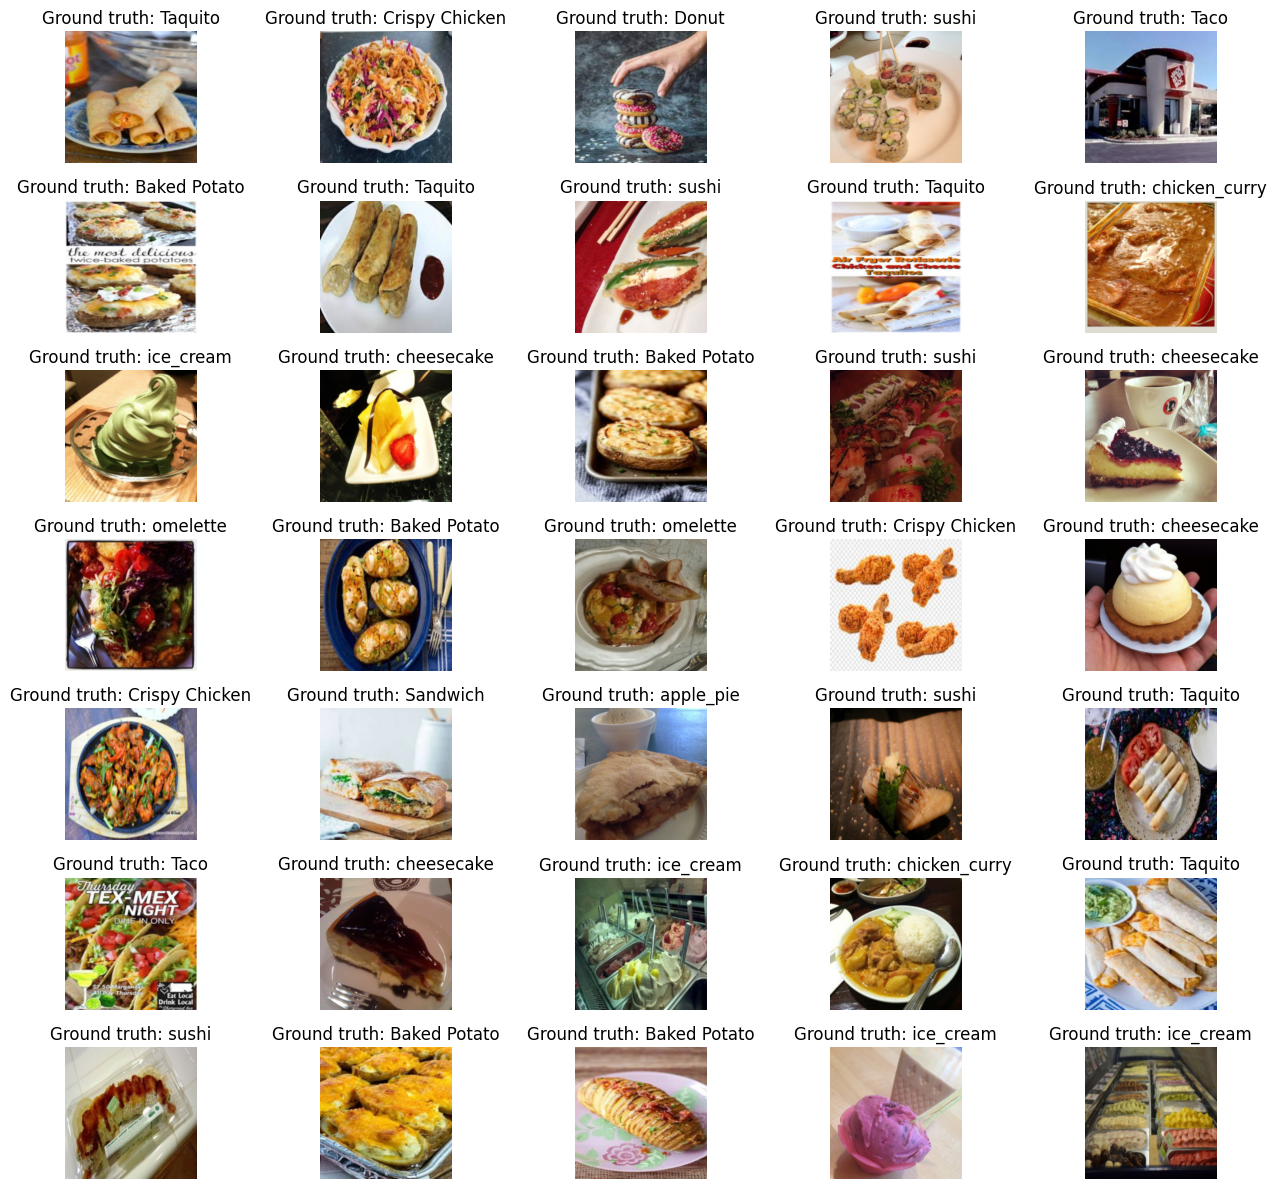

In [22]:
dataset_inspection(sub_train_loader, int_to_labels = int_to_labels,
                   num_images = 35, num_columns = 5, size = (15, 12))

In [23]:
################# THIS CELL IS NEEDED ONLY THE FIRST TIME TO EXPLORE THE DATASET #################

def inspect_dataloader(dataloader, loader_type = None):
  """
  Scope: this function checks the labels distribution and computes [mean, standard
         deviation] of a dataloader;
  Input: a PyTorch DataLoader object;
  Return: mean and standard deviation of the dataset associated to the DataLoader, in RGB format.
  """
  if loader_type is not None:
    print(f"\n\t\t\t\t\tINSPECTING THE {loader_type} DATASET")

  all_labels = []

  mean_sum = torch.zeros(3)
  square_sum = torch.zeros(3)
  total_pixels = 0

  for batch_images, batch_labels in tqdm(dataloader):
    B, C, H, W = batch_images.shape
    num_pixels_in_batch = B * H * W

    mean_sum += torch.sum(batch_images, dim = [0, 2, 3])
    square_sum += torch.sum(batch_images**2, dim = [0, 2, 3])

    all_labels.extend(batch_labels.tolist())
    total_pixels += num_pixels_in_batch

  mean_rgb = (mean_sum/total_pixels)
  mean_square_rgb = square_sum/total_pixels
  std_rgb = (torch.sqrt(mean_square_rgb - mean_rgb ** 2)) # very defintion of std dev

  all_labels = np.array(all_labels)
  labels_unique, label_counts = np.unique(all_labels, return_counts = True)
  total_labels = len(all_labels)
  for label, count in zip(labels_unique, label_counts):
    percentage = np.round(count/total_labels * 100, 2)
    print(f"\nThere are {count} images ({percentage}%) belonging to class {label}.")

  print(f"The mean is {np.round(mean_rgb.numpy(),3)} and the standard deviation is {np.round(std_rgb.numpy(),3)}.\n")

  return [mean_rgb, std_rgb]

mean_rgb, std_rgb = inspect_dataloader(sub_train_loader, loader_type = "TRAIN")
_, _ = inspect_dataloader(sub_valid_loader, loader_type = "VALIDATION")
_, _ = inspect_dataloader(sub_test_loader, loader_type = "TEST")



					INSPECTING THE TRAIN DATASET


100%|██████████| 8/8 [00:02<00:00,  2.94it/s]



There are 72 images (7.2%) belonging to class 0.

There are 71 images (7.1%) belonging to class 1.

There are 71 images (7.1%) belonging to class 2.

There are 72 images (7.2%) belonging to class 3.

There are 71 images (7.1%) belonging to class 4.

There are 71 images (7.1%) belonging to class 5.

There are 72 images (7.2%) belonging to class 6.

There are 71 images (7.1%) belonging to class 7.

There are 72 images (7.2%) belonging to class 8.

There are 72 images (7.2%) belonging to class 9.

There are 72 images (7.2%) belonging to class 10.

There are 71 images (7.1%) belonging to class 11.

There are 71 images (7.1%) belonging to class 12.

There are 71 images (7.1%) belonging to class 13.
The mean is [0.614 0.51  0.411] and the standard deviation is [0.276 0.284 0.304].


					INSPECTING THE VALIDATION DATASET


100%|██████████| 2/2 [00:00<00:00,  2.30it/s]



There are 18 images (7.2%) belonging to class 0.

There are 18 images (7.2%) belonging to class 1.

There are 18 images (7.2%) belonging to class 2.

There are 18 images (7.2%) belonging to class 3.

There are 18 images (7.2%) belonging to class 4.

There are 18 images (7.2%) belonging to class 5.

There are 18 images (7.2%) belonging to class 6.

There are 18 images (7.2%) belonging to class 7.

There are 18 images (7.2%) belonging to class 8.

There are 18 images (7.2%) belonging to class 9.

There are 18 images (7.2%) belonging to class 10.

There are 18 images (7.2%) belonging to class 11.

There are 17 images (6.8%) belonging to class 12.

There are 17 images (6.8%) belonging to class 13.
The mean is [0.613 0.507 0.4  ] and the standard deviation is [0.277 0.285 0.307].


					INSPECTING THE TEST DATASET


100%|██████████| 3/3 [00:01<00:00,  2.84it/s]


There are 23 images (7.37%) belonging to class 0.

There are 22 images (7.05%) belonging to class 1.

There are 22 images (7.05%) belonging to class 2.

There are 23 images (7.37%) belonging to class 3.

There are 22 images (7.05%) belonging to class 4.

There are 22 images (7.05%) belonging to class 5.

There are 22 images (7.05%) belonging to class 6.

There are 22 images (7.05%) belonging to class 7.

There are 23 images (7.37%) belonging to class 8.

There are 23 images (7.37%) belonging to class 9.

There are 22 images (7.05%) belonging to class 10.

There are 22 images (7.05%) belonging to class 11.

There are 22 images (7.05%) belonging to class 12.

There are 22 images (7.05%) belonging to class 13.
The mean is [0.607 0.493 0.38 ] and the standard deviation is [0.277 0.28  0.295].



Dall'esecuzione della cella precedente, vediamo che le classi sono perfettamente bilanciate, che il test set rappresenta esattamente il 20% dei dati totali, e che le $(\mu\,, \sigma)$ sui vari set sono simili (come ci si aspetta, d'altronde!).

## Transfer Learning (and data augmentation)

Dalla sezione precedente, abbiamo $(\mu, \sigma)$ del train set. Possiamo quindi passare ad utilizzare un modello pre-trainato (ConvNeXt) con delle piccole modifiche:

- ConvNeXt è allenato sulle 1000 classi di ImageNet. Dovremo sicuramente cambiare la testa di classificazione mettendo le 14 classi del presente dataset e fare almeno un veloce training (anche solo della nuova testa di classificazione);

- Data la grande potenza di un modello allenato su ImageNet, avremo di sicuro overfitting. Sara' quindi necessario introdurre un minimo di data augmentation.

Possiamo quindi procedere a definire delle trasformazioni "baseline", su cui applicare i nostri modelli.  Testero' alcuni modelli base su cui fare transfer learning. Uno piccolo (EfficientNet-B0), uno medio (ConvNeXt-Tiny/ResNet50) ed uno grande (VGG16):


In [24]:
from torchvision.models import convnext_tiny, ConvNeXt_Tiny_Weights

################## BASELINE MODEL: ConvNeXt_Tiny ##################
convnext_full = convnext_tiny(weights = ConvNeXt_Tiny_Weights.IMAGENET1K_V1)
for param in convnext_full.features.parameters():
  param.requires_grad = False

Per definire le augmentations, useremo albumentations (che e' piu' flessibile di torchvision per la data augmentation!). A tal fine, e' necessario definire una classe Transform:

In [25]:
class Transforms:
  def __init__(self, augmentations):
    self._augmentations = augmentations
  def __call__(self, img, *args, **kwargs):
    return self._augmentations(image = np.array(img))['image']

In [39]:
MEAN_RGB = [0.614, 0.510, 0.411] # mean found in the previous section
STD_RGB = [0.276, 0.284, 0.304] # std dev found in the previous section
RESIZE_DIM = 224 # this is an hyperparameter

# augmented transformation for the training set
augmented_transformations = A.Compose([
    A.Resize(RESIZE_DIM, RESIZE_DIM),
    A.Normalize(mean = MEAN_RGB, std = STD_RGB),
    A.RandomRotate90(),
    A.HorizontalFlip(),
    A.VerticalFlip(),
    A.OneOf([A.Affine(shear = 20), A.Affine(scale = 1.2)],
             p = 0.6),
    A.Transpose(),
    ToTensorV2()])

# basic transformations for the other sets
baseline_transformations = A.Compose([
    A.Resize(RESIZE_DIM, RESIZE_DIM),
    A.Normalize(mean = MEAN_RGB, std = STD_RGB),
    ToTensorV2()])

train_dataset = torchvision.datasets.ImageFolder(train_path,
                                                 transform = Transforms(augmented_transformations))
valid_dataset = torchvision.datasets.ImageFolder(valid_path,
                                                 transform = Transforms(baseline_transformations))
test_dataset = torchvision.datasets.ImageFolder(test_path,
                                                 transform = Transforms(baseline_transformations))

train_loader = data_utils.DataLoader(train_dataset, batch_size = 128, shuffle = True,
                                     num_workers = 2, pin_memory = True)
valid_loader = data_utils.DataLoader(valid_dataset, batch_size = 128, shuffle = False,
                                     num_workers = 2, pin_memory = True)
test_loader = data_utils.DataLoader(test_dataset, batch_size = 128, shuffle = True,
                                    num_workers = 2, pin_memory = True)

Il modello baseline qui sotto aggiunge il minor numero possibile di parametri, nel senso che la testa di classificazione non ha layer nascosti. In pratica, e' come fare logistic regression dopo l'estrazione delle features:

In [27]:
class BaselineModel(nn.Module):
  def __init__(self, backbone: nn.Module, N_f: int = 2):
    """
    backbone: a nn.Module, which extracts the features;
    N_f: the number of feature maps in output of the backbone
    """
    super().__init__()
    self.features = backbone
    self.N_f = N_f
    self.classification_head = nn.Sequential(
        nn.AdaptiveAvgPool2d((1, 1)), # X.shape: [B, N_f, 1, 1]
        nn.Flatten(), # X.shape: [B, N_f]
        nn.Linear(self.N_f, 14)) # X.shape: [B, 14]

  def forward(self, X): # X.shape: [B, C = 3, RESIZE_DIM, RESIZE_DIM]
    X = self.features(X)  # X.shape: [B, N_f, ..., ...]
    X = self.classification_head(X) # X.shape: [B, 14]
    return X

X_example = torch.randn((1, 3, RESIZE_DIM, RESIZE_DIM)) # useful to uncover automatically N_f, the number of filters for the models

N_f_convnext = convnext_full.features(X_example).shape[1]

## Training and Test

Visto che su colab si hanno poche risorse computazionali, il tempo speso a fare training dovra' essere il minore possibile. Per questo motivo sara' fondamentale gestire al meglio il numero di epoche (attraverso la classe `EarlyStopping` -con poca `patience`- definita all'inizio) ed anche la velocita' del training (eventualmente diminuendo il batch size). Infine, la funzione per il train del modello definita all'inizio sfrutta la mixed precision di PyTorch per velocizzare alcuni passaggi. Il settaggio dei `num_workers`nei dataloader ed il fatto di aver copiato il dataset su Colab, e' un'ulteriore fonte di velocita'.

**NB**: in senso assoluto, si dovrebbe fare hyperparameter tuning, ma non si potra' farlo in questo contesto in quanto richiederebbe troppe risorse di calcolo.

In [28]:
baseline_convnext = BaselineModel(backbone = convnext_full.features,
                                  N_f = N_f_convnext).to(device)

EPOCHS = 250
BASELINE_SAVE = "./baseline_convnext.pt"

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params = baseline_convnext.parameters(), lr = 0.0005)
early_stopping = EarlyStopping(path = BASELINE_SAVE)

IL codice sottostante e' commentato perche' il modello viene ricaricato da drive:

 72%|███████▏  | 179/250 [1:21:41<32:24, 27.38s/it]


Early stopping triggered.


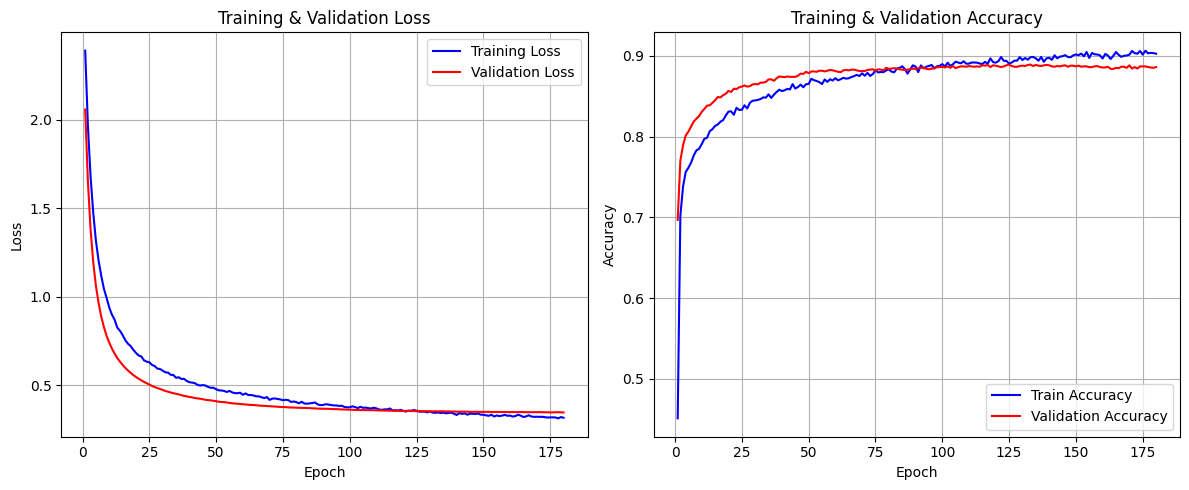

In [28]:
# [train_losses, train_accuracies, val_losses, val_accuracies], [y_train, yhat_train, y_val, yhat_val] = \
#                train_classification(baseline_convnext, loss_fn, optimizer,
#                                      train_loader, valid_loader,
#                                      epochs = EPOCHS, verbose = False,
#                                      confusion_matrix_data = True,
#                                      early_stopping = early_stopping)
#
# baseline_convnext.load_state_dict(torch.load(BASELINE_SAVE))

# training_results(train_losses, train_accuracies, val_losses, val_accuracies, size = (12, 5))

,Accuracy,F1-score,Precision,Recall
Train,0.910156,0.910224,0.910456,0.910156
Validation/Test,0.886607,0.886644,0.887471,0.886607


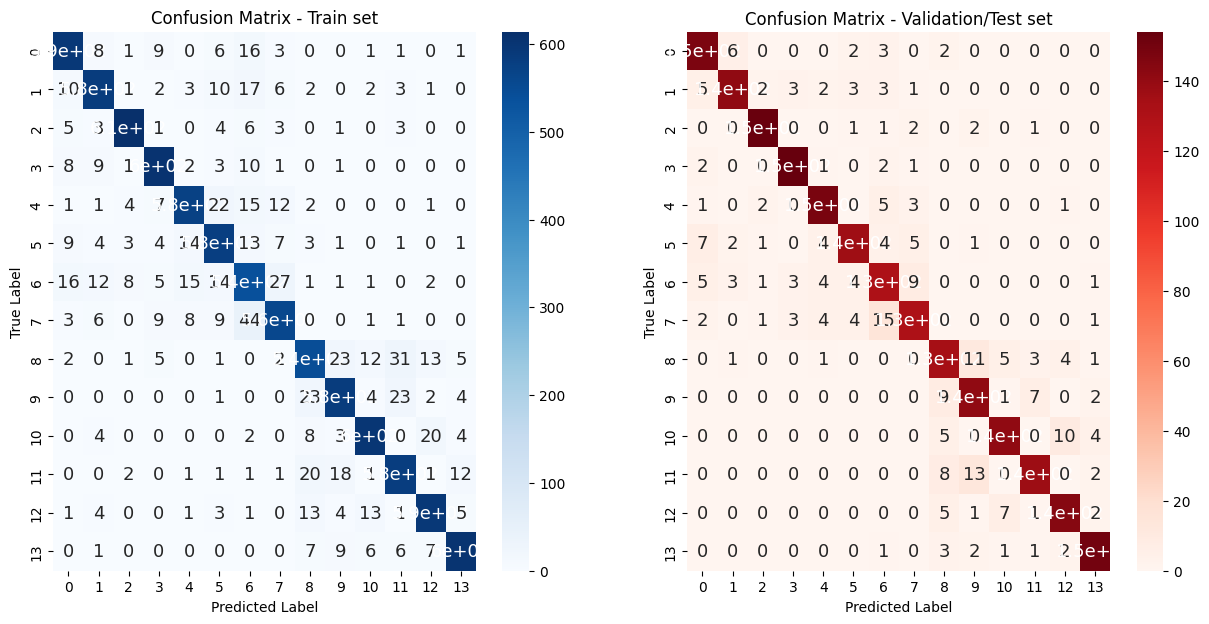

In [ ]:
# metrics_train, metrics_val, metrics_df, confusion_matrices = metrics_report(y_train, yhat_train, y_val, yhat_val,
#                                                                            verbose = True, size = (15, 7))

Salviamo il modello per non doverlo addestrare nuovamente:

In [29]:
# from google.colab import files

checkpoint_path = "baseline_convnext_checkpoint.pt"
# torch.save({'model_state_dict': baseline_convnext.state_dict(),
#            'optimizer_state_dict': optimizer.state_dict(),
#            'lr': optimizer.param_groups[0]['lr']},
#           checkpoint_path)

# files.download(checkpoint_path)

In [30]:
CKPT_PATH = os.path.join("/drive/Othercomputers/Il mio MacBook Pro/My notebooks/Profession AI - AI Engineering/Corso 11: Explainable AI (XAI)/Progetto", checkpoint_path)

# copy the content to colab
!cp "$CKPT_PATH" "$checkpoint_path"

checkpoint = torch.load(checkpoint_path)
baseline_convnext.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

Il modello performa piuttosto bene sul trainval set (train e validation set). Vediamo come performa sul test set:

,Accuracy,F1-score,Precision,Recall
Test,0.883929,0.883772,0.884139,0.883929


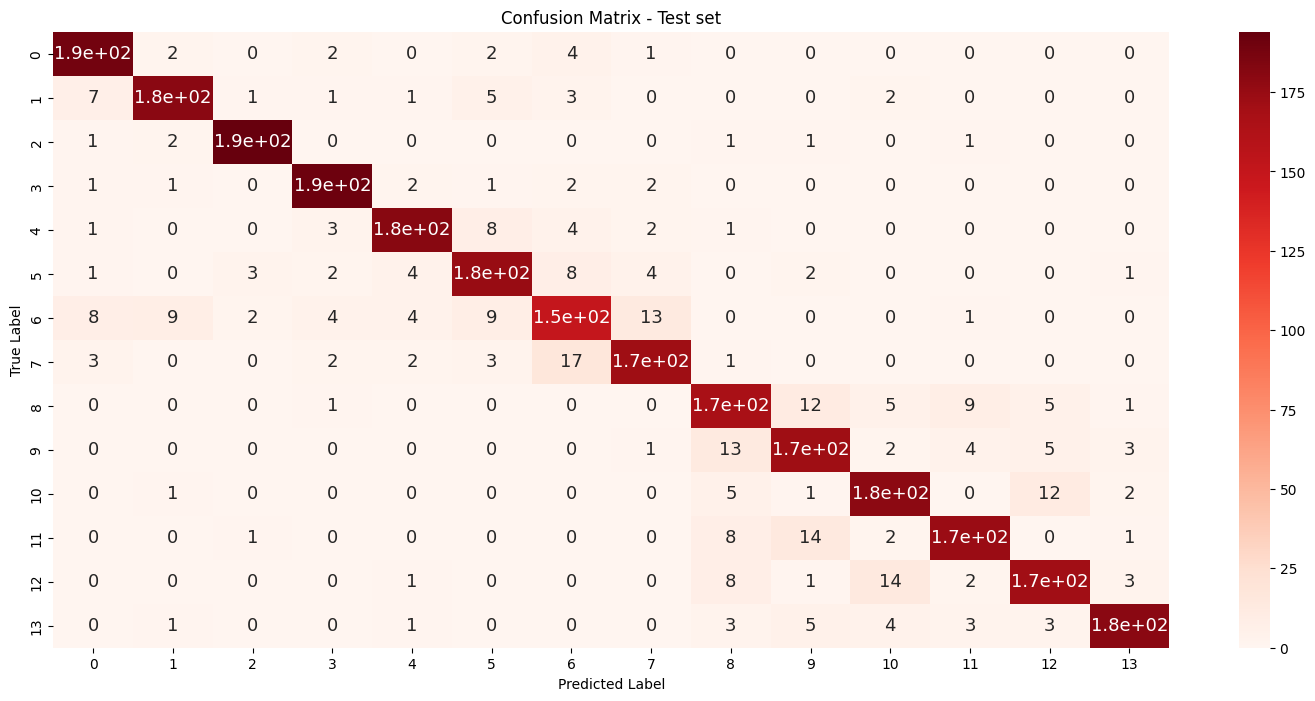

In [40]:
metrics_test, metrics_df, cm_test = test_model(baseline_convnext, loss_fn, test_loader, verbose = True, size = (18, 8))

Controlliamo visivamente come si comporta il modello sul test set:

In [41]:
show_predictions(baseline_convnext, loader = test_loader,
                 mean = MEAN_RGB, std = STD_RGB,
                 int_to_labels = int_to_labels,
                 num_images = 90, num_columns = 3, size = (17, 70))

Output hidden; open in https://colab.research.google.com to view.

## Explainability and Final Report

Abbiamo quindi un modello piuttosto soddisfacente, con una precisione sul test set del $\sim 88%$. Questo potrebbe essere il modello che "la banca" utilizza ad ora per fare classificazione. Vediamo se possiamo capire meglio come e perche' il modello prende certe decisioni.

Iniziamo a cercare di capire il modello utilizzando delle saliency map sul set di test (con una funzione da me definita). Dopodiché, procederemo ad utilizzare la libreria captum, piu' professionale ma meno personalizzabile:

In [43]:
sm = SaliencyMAP(baseline_convnext)

explain_predictions(sm, test_loader, num_images = 30,
                    cmap = 'hot', transparency = 0.2,
                    mean = MEAN_RGB, std = STD_RGB, size = (12,6))

Output hidden; open in https://colab.research.google.com to view.

Da una prima occhiata a queste 30 immagini, il modello sembra concentrarsi sulle feature giuste. Con questo si intende dire che il modello sembra focalizzarsi piu' sul cibo che sul background, come farebbe un umano tenuto a classificare manualmente queste immagini.

Utilizziamo ora captum per eseguire le visualizzazioni principali di XAI per immagini, cioe' Saliency map, Occlusion map, GradCam ed Integrated Gradients.

In [31]:
!pip install -q captum

In [32]:
from captum.attr import Saliency, Occlusion, IntegratedGradients, LayerGradCam, LayerAttribution

In [33]:
saliency_map = Saliency(baseline_convnext)

occlusion_map = Occlusion(baseline_convnext)

target_layer = baseline_convnext.features[-1]
gradcam_map = LayerGradCam(baseline_convnext, target_layer)

integratedgradients_map = IntegratedGradients(baseline_convnext)

In [51]:
explain_captum_predictions(baseline_convnext, saliency_map,
                           test_loader, num_images = 20,
                           cmap = 'hot', transparency = 0.5,
                           mean = MEAN_RGB, std = STD_RGB, size = (12,6),
                           idx_to_class = int_to_labels)

Output hidden; open in https://colab.research.google.com to view.

In [53]:
explain_captum_predictions(baseline_convnext, occlusion_map,
                           test_loader, num_images = 20,
                           cmap = 'hot', transparency = 0.5,
                           mean = MEAN_RGB, std = STD_RGB, size = (12,6),
                           idx_to_class = int_to_labels)

Output hidden; open in https://colab.research.google.com to view.

In [54]:
explain_captum_predictions(baseline_convnext, gradcam_map,
                           test_loader, num_images = 20,
                           cmap = 'hot', transparency = 0.5,
                           mean = MEAN_RGB, std = STD_RGB, size = (12,6),
                           idx_to_class = int_to_labels)

Output hidden; open in https://colab.research.google.com to view.

In [56]:
explain_captum_predictions(baseline_convnext, integratedgradients_map,
                           test_loader, num_images = 20,
                           cmap = 'hot', transparency = 0.5,
                           mean = MEAN_RGB, std = STD_RGB, size = (12,6),
                           idx_to_class = int_to_labels)

Output hidden; open in https://colab.research.google.com to view.

Per investigare ancora di piu' il modello, osserviamo (dalla matrice di confusione del test set) che esso confonde molto le classi $6-7$ e le classi $8-9$, che corrispondono a "taco-taquito" e "apple pie-cheesecake", rispettivamente. Avendo osservato inizialmente le immagini del dataset, appariva gia' chiaro che anche un umano potrebbe confondere tali immagini, essendo molto simili. Ciononostante, possiamo usare la funzione creata all'inizio `find_specific_mistakes`per trovare esattamente le immagini che avevo etichetta $6$ ma classificate come $7$ (e similmente per $8$ e $9$).

Iniziamo con le classi $6-7$:

In [64]:
erratic_images = 10

X_err, y_err = find_specific_mistakes(baseline_convnext, test_loader,
                                      true_label = 6, predicted_label = 7,
                                      max_images = erratic_images)

L'esecuzione della prossima cella risponde a "cosa ha guardato il modello per dire che un'immagine appartiene alla classe $7$ quando invece appartiene alla classe $6$?"

In [63]:
explain_captum_predictions(baseline_convnext, saliency_map, loader = None,
                           external_batch = (X_err, y_err), num_images = erratic_images,
                           class_idx = 7, idx_to_class = int_to_labels,
                           mean = MEAN_RGB, std = STD_RGB, size = (12,6))

Output hidden; open in https://colab.research.google.com to view.

La prossima cella invece risponde a "in cosa il modello non e' sicuro? Perche' non e' sicuro della classe $6$ e assegna l'immagine alla classe $7$? Cosa il modello si sta perdendo?"

In [65]:
explain_captum_predictions(baseline_convnext, saliency_map, loader = None,
                           external_batch = (X_err, y_err), num_images = erratic_images,
                           class_idx = 6, idx_to_class = int_to_labels,
                           mean = MEAN_RGB, std = STD_RGB, size = (12,6))

Output hidden; open in https://colab.research.google.com to view.

Passiamo ora alle classi $8-9$:

In [66]:
X_err, y_err = find_specific_mistakes(baseline_convnext, test_loader,
                                      true_label = 8, predicted_label = 9,
                                      max_images = erratic_images)

In [67]:
explain_captum_predictions(baseline_convnext, saliency_map, loader = None,
                           external_batch = (X_err, y_err), num_images = erratic_images,
                           class_idx = 9, idx_to_class = int_to_labels,
                           mean = MEAN_RGB, std = STD_RGB, size = (12,6))

Output hidden; open in https://colab.research.google.com to view.

In [69]:
explain_captum_predictions(baseline_convnext, saliency_map, loader = None,
                           external_batch = (X_err, y_err), num_images = erratic_images,
                           class_idx = 8, idx_to_class = int_to_labels,
                           mean = MEAN_RGB, std = STD_RGB, size = (12,6))

Output hidden; open in https://colab.research.google.com to view.

Dall'esecuzione delle precedenti celle notiamo che in entrambi i casi il modello si concentra su delle feature sensate anche quando sbaglia. Da questo capiamo che l'errore non sta tanto nel modello quanto nella difficolta' intrinseca del modello. Ribadiamo infatti che anche un umano (senza subject expertise specifica, tipo me) avrebbe chiamato sia le classi $6$ che $7$ come 'taco'.

Come sistema spiegabile, sarebbe interessante creare una funzione che, prendendo come riferimento ad esempio le mappe di salienza, faccia quanto segue:

- prenda una mappa di salienza derivante dall'analisi di una immagine nel dataset;

- guardi i piexels piu' illuminati (Quanti? Quali? Come?) e ne memorizzi le posizioni;

- estragga dall'immagine originale quei pixels (che presumibilmente vanno a formare una zona piu' o meno contigua), salvando una 'figura';

- mostri all'utente la decisione presa, aggiungendo una frase del tipo: f"Il modello ha attribuito a questo campione la classe {classe} perche' nell'immagine e' presente questa {figura}".

Idealmente, su un esempio semplice di classificazione fra gatti e uccelli, il modello direbbe che la classe assegnata è 'gatto' mostrando per esempio l'immagine di orecchie o zampe, mentre 'uccello' mostrando le ali.